1. Lowpass first 80Hz then hipass 0.1Hz
2. Downsample to 250Hz
3. Cut out the joystick part.
4. Run ICA
5. Remove only ECG and EOG
6. Apply ICA to full dataset
7. Epoch and baseline only to the trial onset.

In [228]:
from tqdm import tqdm
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
from scipy.stats import trim_mean, ttest_1samp, sem
import numpy as np
%matplotlib

Using matplotlib backend: Qt5Agg


In [2]:
ds = "/cubric/scratch/c1557187/act_mis/MEG/0001/220319-502_371SensMotTrans_20190328_04.ds"

In [3]:
raw = mne.io.read_raw_ctf(ds, preload=True)

In [5]:
raw = raw.filter(
    None,
    80,
    method="fir",
    phase="minimum",
    n_jobs=-1
)

In [7]:
raw = raw.filter(
    0.1,
    None,
    method="fir",
    phase="minimum",
    n_jobs=-1
)

In [8]:
events = mne.find_events(
    raw,
    stim_channel="UPPT001",
    min_duration=0.003
)

In [9]:
raw, events = raw.copy().resample(
    250, 
    npad="auto", 
    events=events,
    n_jobs=-1,
)

In [72]:
start = np.where((events[:,2] < 50))[0]
end = np.where((events[:,2] > 50) & (events[:,2] < 80))[0]
del_ranges = list(zip(events[start][:,0], events[end][:,0]))
ints = np.concatenate([np.arange(i[0], i[1]) for i in del_ranges])

In [65]:
raw_ICA = raw.copy().pick_types(
    meg=True,
    eeg=True,
    eog=True,
    ref_meg=False
)

In [70]:
data = raw_ICA.get_data()
data.shape

(276, 146900)

In [86]:
data = np.delete(data, ints, axis=1)

In [88]:
raw_ICA = mne.io.RawArray(data, raw_ICA.info)

In [90]:
n_components = 50
method = "fastica"
reject = dict(mag=4e-12)
max_iter = 10000

In [91]:
ica = ICA(
    n_components=n_components, 
    method=method,
    max_iter=max_iter
)

In [94]:
ica.fit(
    raw_ICA, 
    reject=reject
)

<ICA  |  raw data decomposition, fit (fastica): 77000 samples, 50 components, channels used: "mag"; "eeg">

In [95]:
set_ch = {'EEG057-3305':'eog', 'EEG058-3305': 'eog'}
raw_ICA.set_channel_types(set_ch)

In [96]:
eog_ix, eog_scores = ica.find_bads_eog(
    raw_ICA, 
    threshold=3.0, 
    l_freq=1, 
    h_freq=10, 
    verbose=False
)

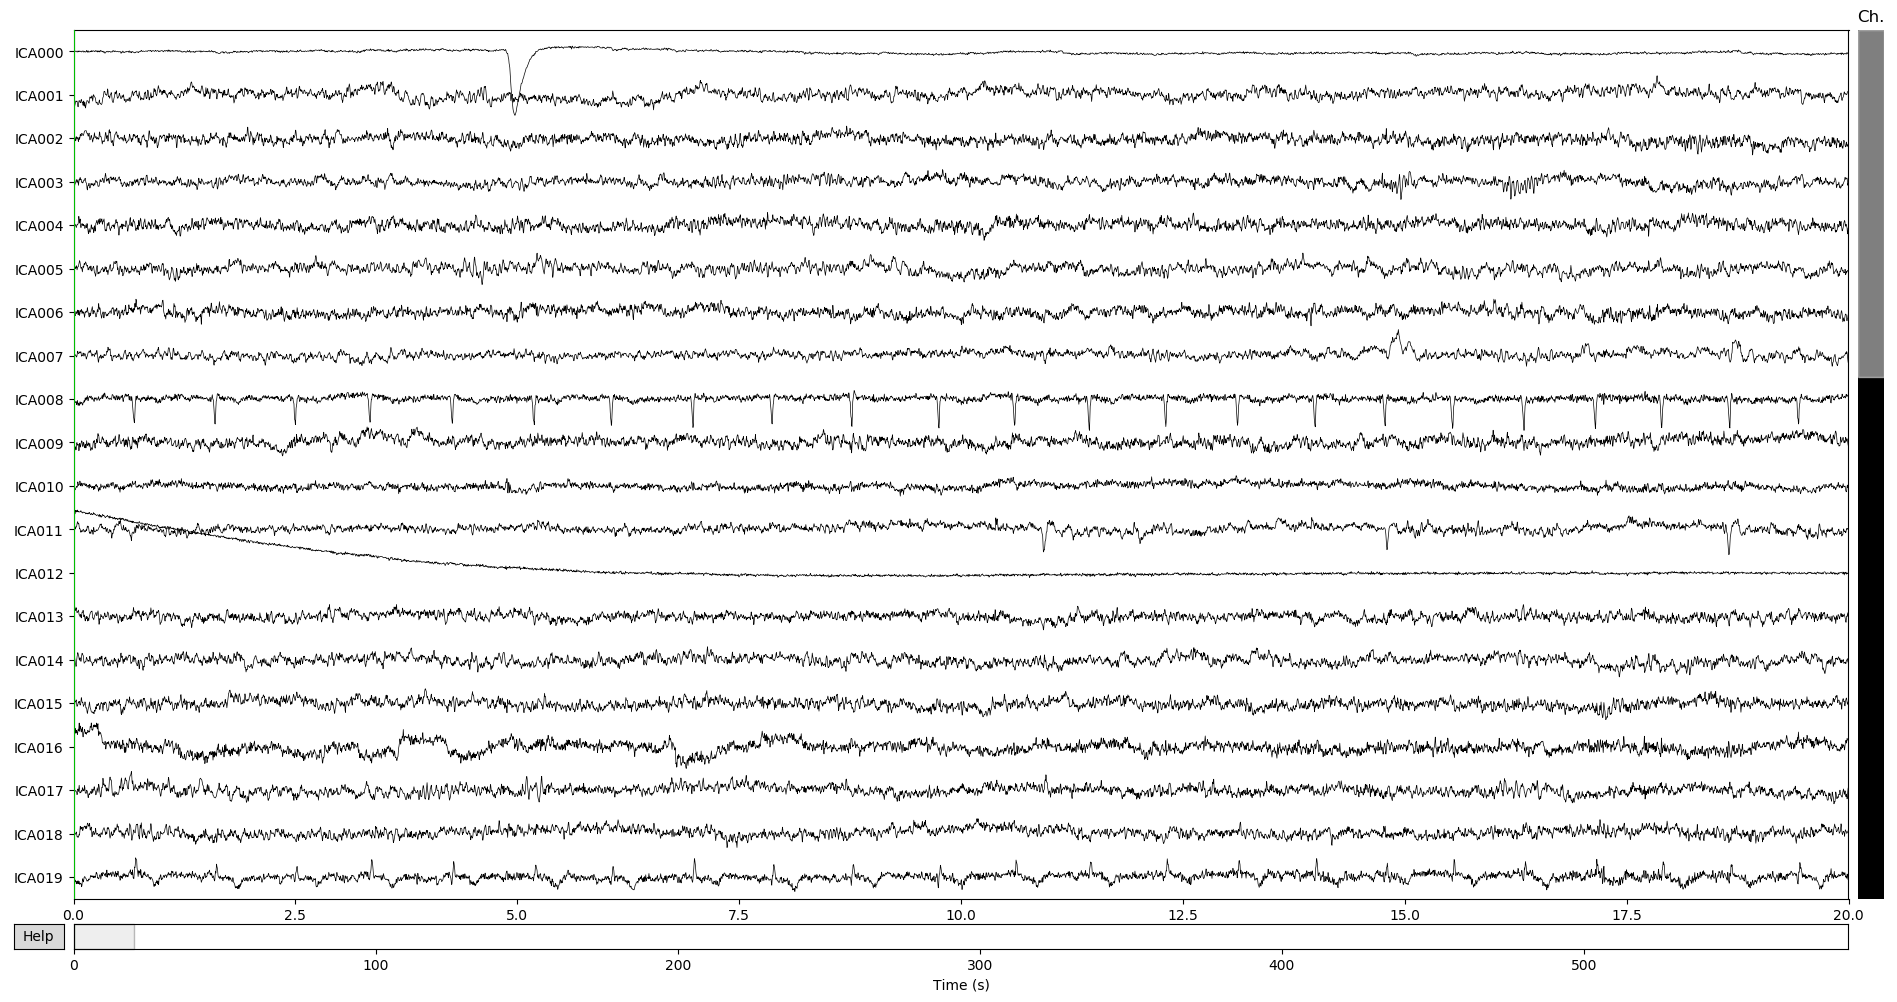

In [97]:
ica.plot_scores(eog_scores, exclude=eog_ix)
ica.plot_components()
ica.plot_sources(raw)

In [98]:
reject_components = [0, 8, 12, 16, 19]

In [99]:
raw_ica = ica.apply(
    raw,
    exclude=reject_components
)

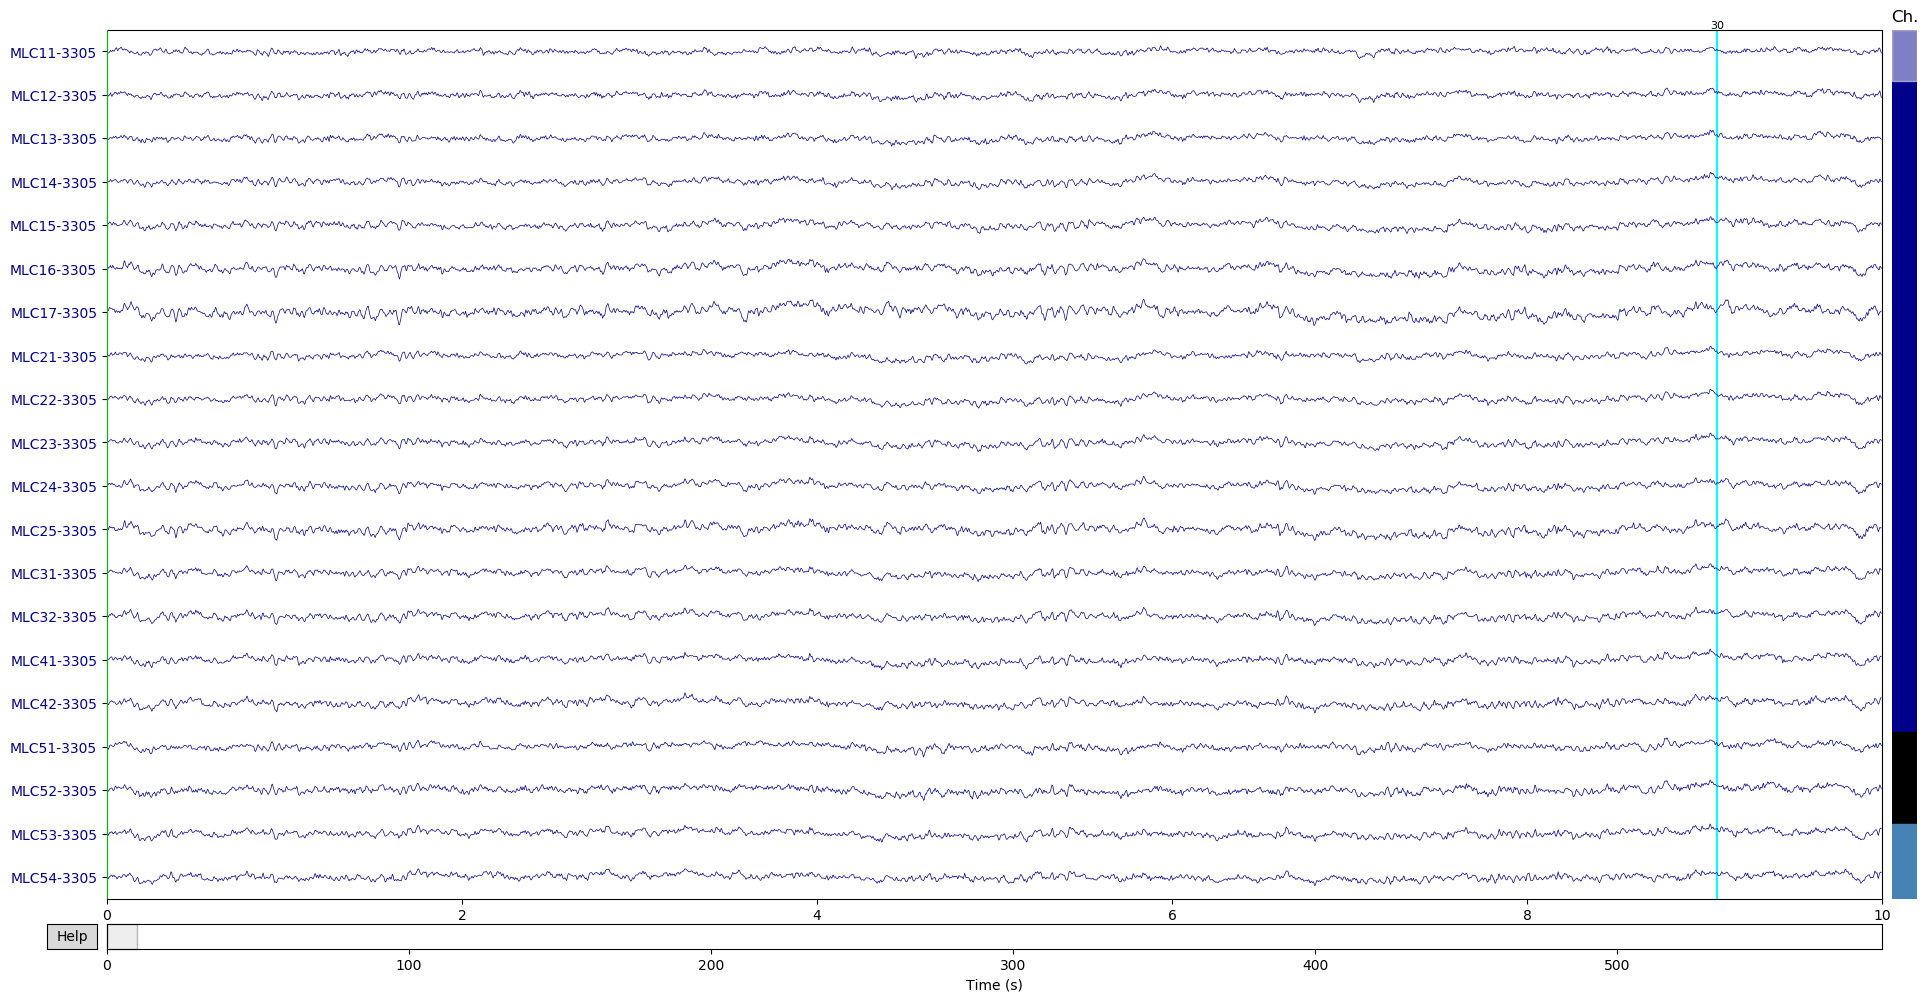

In [100]:
raw_ica.plot(events=events)

In [103]:
onsets, ends = events[start][:,0], events[end][:,0]


In [115]:
durations = ends - onsets
cutouts = np.int_(durations - 1.5*250)

In [186]:
np.int_(durations + 1.1 * 250 - cutouts + 0.5*250)

array([775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775,
       775, 775, 775, 775, 775, 775, 775, 775, 775, 775])

In [187]:
epochs = mne.Epochs(
    raw_ica.pick_types(meg=True, eog=True, eeg=True, ref_meg=False),
    events=events,
    baseline=None,
    preload=True,
    event_id=[30, 40],
    tmin=-0.5,
    tmax=np.max(durations/250 + 1.1 + 1.5)
)

In [188]:
epochs_array = []
for ix, epo in enumerate(list(epochs.iter_evoked())):
    data = epo.data
    del_ints = np.arange(500, 500+cutouts[ix])
    data = np.delete(data, del_ints, axis=1)
    data = data[:,:775]
    epochs_array.append(data)    

In [190]:
epochs_array = np.array(epochs_array)

In [193]:
epochs_array.shape

(140, 276, 775)

In [199]:
epochs = mne.EpochsArray(
    epochs_array,
    epochs.info,
    events=events[start],
    tmin=-0.5,
    baseline=None
)

# TIME ANALYSIS

In [210]:
baselined_epo = epochs.pick_types(meg=True, eeg=False).apply_baseline((-0.1,0))

In [221]:
erf_epo = baselined_epo.filter(
    None,
    30,
    method="fir",
    phase="minimum",
    n_jobs=-1
)

In [222]:
trim = lambda x: trim_mean(x, 0.1, axis=0)

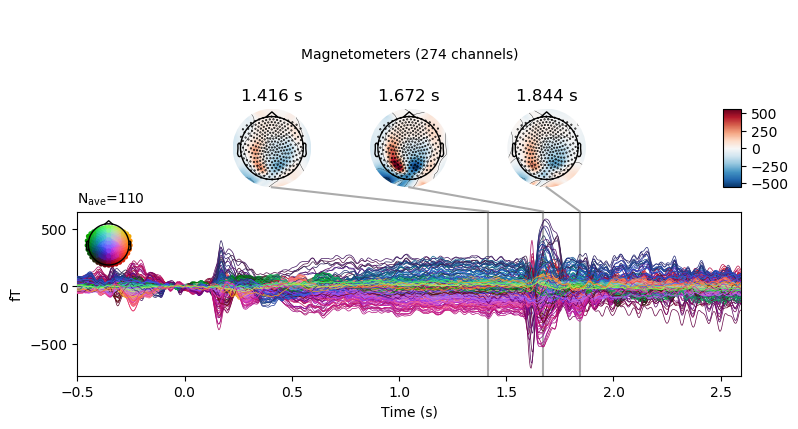

In [223]:
erf_epo["30"].average(method=trim).plot_joint()

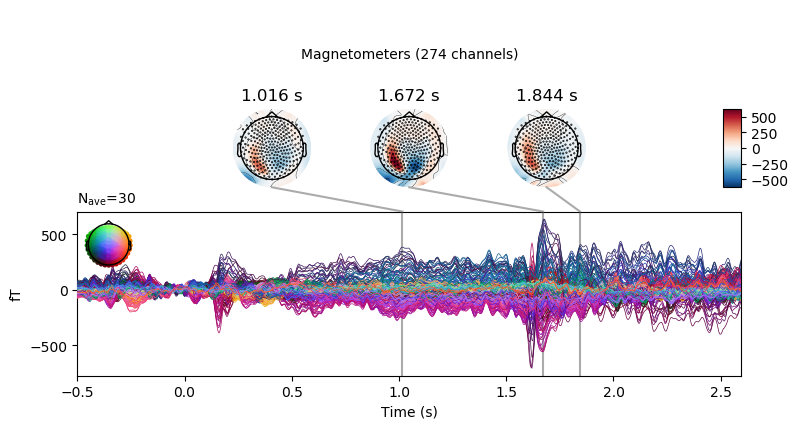

In [225]:
erf_epo["40"].average(method=trim).plot_joint()

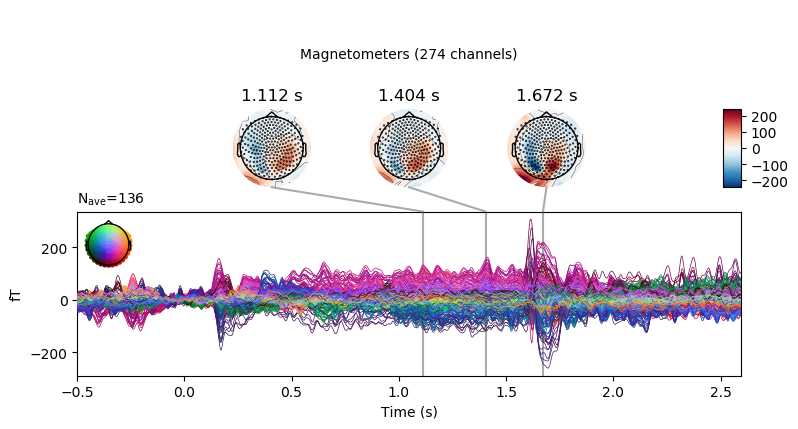

In [226]:
mne.combine_evoked([erf_epo["40"].average(method=trim),-erf_epo["30"].average(method=trim)], weights=[0.286,0.714]).plot_joint()

# TIME FREQUENCY ANALYSIS

In [245]:
freqs = np.linspace(0.1, 90, num=36)
n_cycles = freqs / 2.  # different number of cycle per frequency
power_reg, itc = tfr_morlet(
    epochs["30"], 
    freqs=freqs, 
    n_cycles=n_cycles, 
    use_fft=True,
    return_itc=True, 
    decim=2, 
    n_jobs=-1
)

In [246]:
freqs = np.linspace(0.1, 90, num=36)
n_cycles = freqs / 2.  # different number of cycle per frequency
power_odd, itc = tfr_morlet(
    epochs["40"], 
    freqs=freqs, 
    n_cycles=n_cycles, 
    use_fft=True, 
    decim=2, 
    n_jobs=-1,
    return_itc=True
)

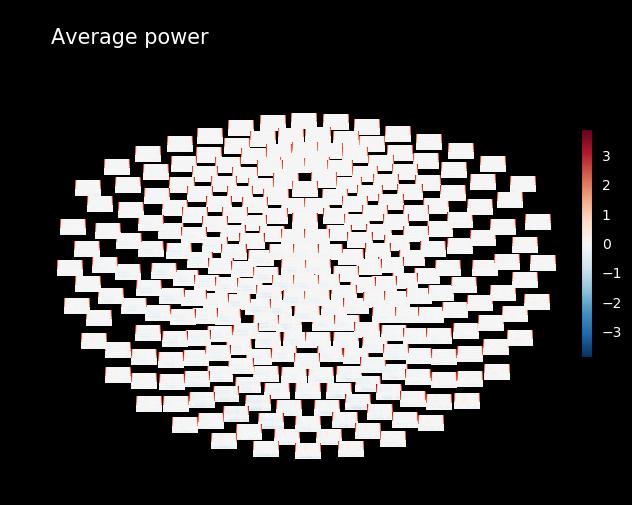

In [249]:
power_reg.plot_topo(baseline=(1.5, 1.6), mode='logratio', title='Average power')